# 4. Randomized Projection & Randomized SVD

## Part 1: Random Projections (with word vectors)

The purpose of this section is to illustrate the idea of **random projections preserving structure** with the concrete example of **word vectors**!

To use language in machine learning (for instance, how Skype translator translates between languages, or how Gmail Smart Reply automatically suggests possible responses for your emails), we need to represent words as vectors.

We can represent words as 100 dimensional vectors, using Google's Word2Vec or Stanford's GloVe.  For example, here is the word "python" as a vector in GloVe:

In [147]:
vecs[wordidx['python']]

array([ 0.2493,  0.6832, -0.0447, -1.3842, -0.0073,  0.651 , -0.3396,
       -0.1979, -0.3392,  0.2669, -0.0331,  0.1592,  0.8955,  0.54  ,
       -0.5582,  0.4624,  0.3672,  0.1889,  0.8319,  0.8142, -0.1183,
       -0.5346,  0.2416, -0.0389,  1.1907,  0.7935, -0.1231,  0.6642,
       -0.7762, -0.4571, -1.054 , -0.2056, -0.133 ,  0.1224,  0.8846,
        1.024 ,  0.3229,  0.821 , -0.0694,  0.0242, -0.5142,  0.8727,
        0.2576,  0.9153, -0.6422,  0.0412, -0.6021,  0.5463,  0.6608,
        0.198 , -1.1393,  0.7951,  0.4597, -0.1846, -0.6413, -0.2493,
       -0.4019, -0.5079,  0.8058,  0.5336,  0.5273,  0.3925, -0.2988,
        0.0096,  0.9995, -0.0613,  0.7194,  0.329 , -0.0528,  0.6714,
       -0.8025, -0.2579,  0.4961,  0.4808, -0.684 , -0.0122,  0.0482,
        0.2946,  0.2061,  0.3356, -0.6417, -0.6471,  0.1338, -0.1257,
       -0.4638,  1.3878,  0.9564, -0.0679, -0.0017,  0.5296,  0.4567,
        0.6104, -0.1151,  0.4263,  0.1734, -0.7995, -0.245 , -0.6089,
       -0.3847, -0.4

**Goal**: Use randomness to reduce this from 100 dimensions to 20.  Check that similar words are still grouped together.

**More info**: If you are interested in word embeddings and want more detail, I gave a longer workshop about them [available here](https://www.youtube.com/watch?v=25nC0n9ERq4) (with [code demo](https://github.com/fastai/word-embeddings-workshop)).

**Style note**: I use [collapsible headings](http://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/collapsible_headings/readme.html) and [jupyter themes](https://github.com/dunovank/jupyter-themes)

#### Loading the data

In [1]:
import pickle
import numpy as np
import re
import json

In [2]:
np.set_printoptions(precision=4, suppress=True)

The dataset is available at http://files.fast.ai/models/glove/6B.100d.tgz
To download and unzip the files from the command line, you can run:

    wget http://files.fast.ai/models/glove_50_glove_100.tgz 
    tar xvzf glove_50_glove_100.tgz

You will need to update the path below to be accurate for where you are storing the data.

In [3]:
path = "../data/"

In [4]:
vecs = np.load(path + "glove_vectors_100d.npy")

In [5]:
with open(path + "words.txt") as f:
    content = f.readlines()
words = [x.strip() for x in content] 

In [6]:
wordidx = json.load(open(path + "wordsidx.txt"))

#### What our data looks like

We have a long list of words:

In [7]:
len(words)

400000

In [8]:
words[:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [9]:
words[600:610]

['together',
 'congress',
 'index',
 'australia',
 'results',
 'hard',
 'hours',
 'land',
 'action',
 'higher']

wordidx allows us to look up a word in order to find out it's index:

In [10]:
wordidx['python']

20019

In [11]:
words[20019]

'python'

### Words as vectors

The word "python" is represented by the 100 dimensional vector:

In [12]:
vecs[wordidx['python']]

array([ 0.2493,  0.6832, -0.0447, -1.3842, -0.0073,  0.651 , -0.3396,
       -0.1979, -0.3392,  0.2669, -0.0331,  0.1592,  0.8955,  0.54  ,
       -0.5582,  0.4624,  0.3672,  0.1889,  0.8319,  0.8142, -0.1183,
       -0.5346,  0.2416, -0.0389,  1.1907,  0.7935, -0.1231,  0.6642,
       -0.7762, -0.4571, -1.054 , -0.2056, -0.133 ,  0.1224,  0.8846,
        1.024 ,  0.3229,  0.821 , -0.0694,  0.0242, -0.5142,  0.8727,
        0.2576,  0.9153, -0.6422,  0.0412, -0.6021,  0.5463,  0.6608,
        0.198 , -1.1393,  0.7951,  0.4597, -0.1846, -0.6413, -0.2493,
       -0.4019, -0.5079,  0.8058,  0.5336,  0.5273,  0.3925, -0.2988,
        0.0096,  0.9995, -0.0613,  0.7194,  0.329 , -0.0528,  0.6714,
       -0.8025, -0.2579,  0.4961,  0.4808, -0.684 , -0.0122,  0.0482,
        0.2946,  0.2061,  0.3356, -0.6417, -0.6471,  0.1338, -0.1257,
       -0.4638,  1.3878,  0.9564, -0.0679, -0.0017,  0.5296,  0.4567,
        0.6104, -0.1151,  0.4263,  0.1734, -0.7995, -0.245 , -0.6089,
       -0.3847, -0.4

This lets us do some useful calculations. For instance, we can see how far apart two words are using a distance metric:

In [13]:
from scipy.spatial.distance import cosine as dist

Smaller numbers mean two words are closer together, larger numbers mean they are further apart.

The distance between similar words is low:

In [14]:
dist(vecs[wordidx["puppy"]], vecs[wordidx["dog"]])

0.27636240676695256

In [15]:
dist(vecs[wordidx["queen"]], vecs[wordidx["princess"]])

0.20527545040329642

And the distance between unrelated words is high:

In [16]:
dist(vecs[wordidx["celebrity"]], vecs[wordidx["dusty"]])

0.98835787578057777

In [17]:
dist(vecs[wordidx["avalanche"]], vecs[wordidx["antique"]])

0.96211070091611983

#### Bias

There is a lot of opportunity for bias:

In [18]:
dist(vecs[wordidx["man"]], vecs[wordidx["genius"]])

0.50985148631697985

In [19]:
dist(vecs[wordidx["woman"]], vecs[wordidx["genius"]])

0.6897833082810727

I just checked the distance between pairs of words, because this is a quick and simple way to illustrate the concept.  It is also a very **noisy** approach, and **researchers approach this problem in more systematic ways**.

I talk about bias in much greater depth in [this workshop](https://www.youtube.com/watch?v=25nC0n9ERq4).

### Visualizations

Let's visualize some words!

We will use [Plotly](https://plot.ly/), a Python library to make interactive graphs (note: everything below is done without creating an account, with the free, offline version of Plotly).

#### Methods

In [20]:
import plotly
import plotly.graph_objs as go    
from IPython.display import IFrame

In [21]:
def plotly_3d(Y, cat_labels, filename="temp-plot.html"):
    trace_dict = {}
    for i, label in enumerate(cat_labels):
        trace_dict[i] = go.Scatter3d(
            x=Y[i*5:(i+1)*5, 0],
            y=Y[i*5:(i+1)*5, 1],
            z=Y[i*5:(i+1)*5, 2],
            mode='markers',
            marker=dict(
                size=8,
                line=dict(
                    color='rgba('+ str(i*40) + ',' + str(i*40) + ',' + str(i*40) + ', 0.14)',
                    width=0.5
                ),
                opacity=0.8
            ),
            text = my_words[i*5:(i+1)*5],
            name = label
        )

    data = [item for item in trace_dict.values()]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )

    plotly.offline.plot({
        "data": data,
        "layout": layout,
    }, filename=filename)

In [22]:
def plotly_2d(Y, cat_labels, filename="temp-plot.html"):
    trace_dict = {}
    for i, label in enumerate(cat_labels):
        trace_dict[i] = go.Scatter(
            x=Y[i*5:(i+1)*5, 0],
            y=Y[i*5:(i+1)*5, 1],
            mode='markers',
            marker=dict(
                size=8,
                line=dict(
                    color='rgba('+ str(i*40) + ',' + str(i*40) + ',' + str(i*40) + ', 0.14)',
                    width=0.5
                ),
                opacity=0.8
            ),
            text = my_words[i*5:(i+1)*5],
            name = label
        )

    data = [item for item in trace_dict.values()]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )

    plotly.offline.plot({
        "data": data,
        "layout": layout
    }, filename=filename)

This method will pick out the 3 dimensions that best separate our categories from one another (stored in `dist_btwn_cats`), while minimizing the distance of the words within a given category (stored in `dist_within_cats`).

In [33]:
def get_components(data, categories, word_indices):
    num_components = 30
    pca = decomposition.PCA(n_components=num_components).fit(data.T)
    all_components = pca.components_
    centroids = {}
    print(all_components.shape)
    for i, category in enumerate(categories):
        cen = np.mean(all_components[:, i*5:(i+1)*5], axis = 1)
        dist_within_cats = np.sum(np.abs(np.expand_dims(cen, axis=1) - all_components[:, i*5:(i+1)*5]), axis=1)
        centroids[category] = cen
    dist_btwn_cats = np.zeros(num_components)
    for category1, averages1 in centroids.items():
        for category2, averages2 in centroids.items():
            dist_btwn_cats += abs(averages1 - averages2)
            clusterness = dist_btwn_cats / dist_within_cats
    comp_indices = np.argpartition(clusterness, -3)[-3:]
    return all_components[comp_indices]

### Preparing the Data

Let's plot words from a few different categories:

In [24]:
my_words = [
            "maggot", "flea", "tarantula", "bedbug", "mosquito", 
            "violin", "cello", "flute", "harp", "mandolin",
            "joy", "love", "peace", "pleasure", "wonderful",
            "agony", "terrible", "horrible", "nasty", "failure", 
            "physics", "chemistry", "science", "technology", "engineering",
            "poetry", "art", "literature", "dance", "symphony",
           ]

In [25]:
categories = [
              "bugs", "music", 
              "pleasant", "unpleasant", 
              "science", "arts"
             ]

Again, we need to look up the indices of our words using the wordidx dictionary:

In [26]:
my_word_indices = np.array([wordidx[word] for word in my_words])

In [27]:
vecs[my_word_indices].shape

(30, 100)

Now, we will make a set combining our words with the first 10,000 words in our entire set of words (some of the words will already be in there), and create a matrix of their embeddings.

In [29]:
embeddings = np.concatenate((vecs[my_word_indices], vecs[:10000,:]), axis=0); embeddings.shape

(10030, 100)

### Viewing the words in 3D

The words are in 100 dimensions and we need a way to visualize them in 3D. 

We will use Principal Component Analysis (PCA), a widely used technique with many applications, including visualizing high-dimensional data sets in a lower dimension!

#### PCA

In [30]:
from collections import defaultdict
from sklearn import decomposition

In [34]:
components = get_components(embeddings, categories, my_word_indices)
plotly_3d(components.T[:len(my_words),:], categories, "pca.html")

(30, 10030)


In [35]:
IFrame('pca.html', width=600, height=400)

### Random Projections

**Johnson-Lindenstrauss Lemma**: ([from wikipedia](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma)) a small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved (proof uses random projections).

It is useful to be able to reduce dimensionality of data in a way that **preserves distances**. The Johnson–Lindenstrauss lemma is a classic result of this type.

In [36]:
embeddings.shape

(10030, 100)

In [37]:
rand_proj = embeddings @ np.random.normal(size=(embeddings.shape[1], 40)); rand_proj.shape

(10030, 40)

In [39]:
# pca = decomposition.PCA(n_components=3).fit(rand_proj.T)
# components = pca.components_
components = get_components(rand_proj, categories, my_word_indices)
plotly_3d(components.T[:len(my_words),:], categories, "pca-rand-proj.html")

(30, 10030)


In [40]:
IFrame('pca-rand-proj.html', width=600, height=400)

## Part 2: Random SVD for Background Removal

**Our goal today**: ![background removal](images/surveillance3.png)

### Load and Format the Data

Let's use the real video 003 dataset from [BMC 2012 Background Models Challenge Dataset](http://bmc.iut-auvergne.com/?page_id=24)

Import needed libraries:

In [1]:
import imageio
imageio.plugins.ffmpeg.download()

In [2]:
import moviepy.editor as mpe
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
scale = 0.50   # Adjust scale to change resolution of image
dims = (int(240 * scale), int(320 * scale))
fps = 60      # frames per second

In [14]:
M = np.load("movie/med_res_surveillance_matrix_60fps.npy")

In [15]:
print(dims, M.shape)

(120, 160) (19200, 6000)


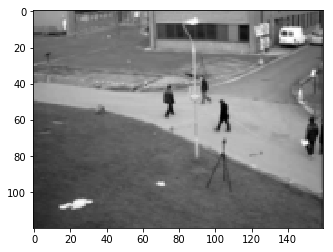

In [27]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

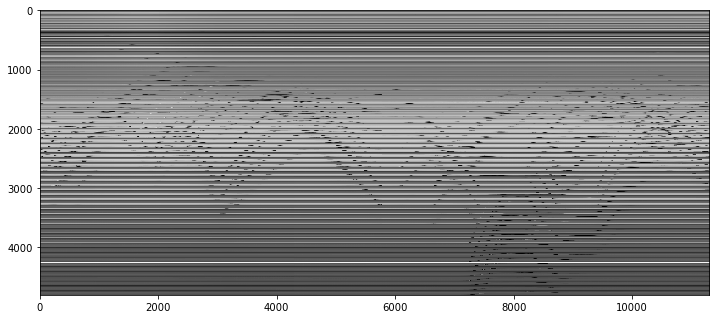

In [33]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

In the future, you can just load what you've saved:

In [6]:
U = np.load("U.npy")
s = np.load("s.npy")
V = np.load("V.npy")

What do $U$, $S$, and $V$ look like?

In [29]:
U.shape, s.shape, V.shape

((19200, 6000), (6000,), (6000, 6000))

Check that they are a decomposition of M

In [30]:
reconstructed_matrix = U @ np.diag(s) @ V

In [31]:
np.allclose(M, reconstructed_matrix)

True

They are! :-)

### Removing the background

In [40]:
low_rank = np.expand_dims(U[:,0], 1) * s[0] * np.expand_dims(V[0,:], 0)

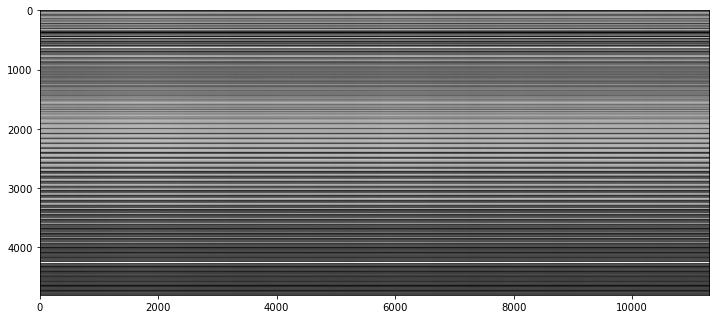

In [360]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

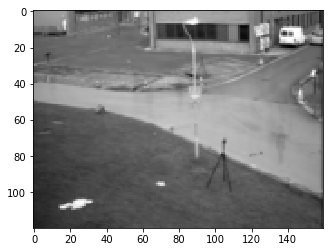

In [41]:
plt.imshow(np.reshape(low_rank[:,0], dims), cmap='gray');

How do we get the people from here?

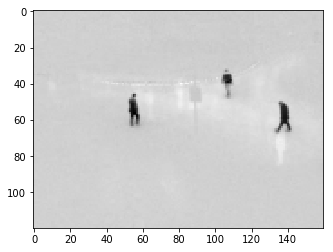

In [42]:
plt.imshow(np.reshape(M[:,0] - low_rank[:,0], dims), cmap='gray');

### Speed of SVD for different size matrices

s is the diagonal of a *diagonal matrix*

In [37]:
np.set_printoptions(suppress=True, precision=4)

In [4]:
import timeit
import pandas as pd

In [5]:
m_array = np.array([100, int(1e3), int(1e4)])
n_array = np.array([100, int(1e3), int(1e4)])

In [6]:
index = pd.MultiIndex.from_product([m_array, n_array], names=['# rows', '# cols'])

In [7]:
pd.options.display.float_format = '{:,.3f}'.format
df = pd.DataFrame(index=m_array, columns=n_array)

In [10]:
# %%prun
for m in m_array:
    for n in n_array:      
        A = np.random.uniform(-40,40,[m,n])  
        t = timeit.timeit('np.linalg.svd(A, full_matrices=False)', number=3, globals=globals())
        df.set_value(m, n, t)

In [12]:
df/3

,100,1000,10000
100,0.006,0.009,0.043
1000,0.004,0.259,0.992
10000,0.019,0.984,218.726


### That's pretty neat!!! but...

**Downside: this was really slow (also, we threw away a lot of our calculation)**

In [51]:
%time u, s, v = np.linalg.svd(M, full_matrices=False)

CPU times: user 5min 38s, sys: 1.53 s, total: 5min 40s
Wall time: 57.1 s


In [52]:
M.shape

(19200, 6000)

#### Simplest Version of Randomized SVD

**Idea**: Let's use a smaller matrix!

We haven't found a better general SVD method, we'll just use the method we have on a smaller matrix that has approximately the same range as our original matrix.

In [1]:
def simple_randomized_svd(M, k=10):
    m, n = M.shape
    transpose = False
    if m < n:
        transpose = True
        M = M.T
        
    rand_matrix = np.random.normal(size=(M.shape[1], k))  # short side by k
    Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced')  # long side by k
    smaller_matrix = Q.T @ M                              # k by short side
    U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)
    U = Q @ U_hat
    
    if transpose:
        return V.T, s.T, U.T
    else:
        return U, s, V

In [59]:
%time u, s, v = simple_randomized_svd(M, 10)

CPU times: user 3.06 s, sys: 268 ms, total: 3.33 s
Wall time: 789 ms


In [60]:
U_rand, s_rand, V_rand = simple_randomized_svd(M, 10)

In [61]:
low_rank = np.expand_dims(U_rand[:,0], 1) * s_rand[0] * np.expand_dims(V_rand[0,:], 0)

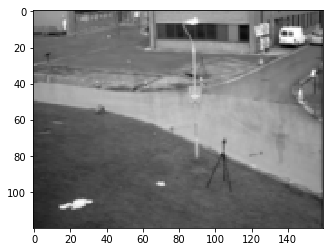

In [62]:
plt.imshow(np.reshape(low_rank[:,0], dims), cmap='gray');

How do we get the people from here?

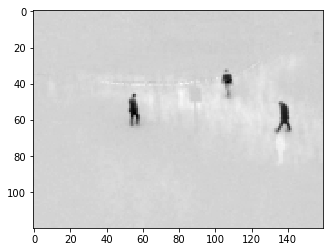

In [63]:
plt.imshow(np.reshape(M[:,0] - low_rank[:,0], dims), cmap='gray');

#### What this method is doing

In [79]:
rand_matrix = np.random.normal(size=(M.shape[1], 10))

In [80]:
rand_matrix.shape

(6000, 10)

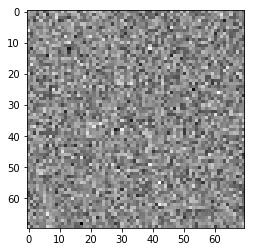

In [81]:
plt.imshow(np.reshape(rand_matrix[:4900,0], (70,70)), cmap='gray');

In [82]:
temp = M @ rand_matrix; temp.shape

(19200, 10)

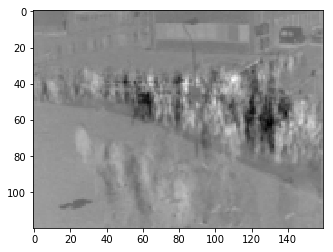

In [83]:
plt.imshow(np.reshape(temp[:,0], dims), cmap='gray');

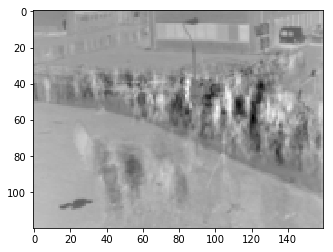

In [84]:
plt.imshow(np.reshape(temp[:,1], dims), cmap='gray');

In [85]:
Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced'); Q.shape

(19200, 10)

In [86]:
np.dot(Q[:,0], Q[:,1])

-3.8163916471489756e-17

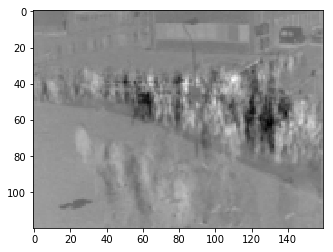

In [87]:
plt.imshow(np.reshape(Q[:,0], dims), cmap='gray');

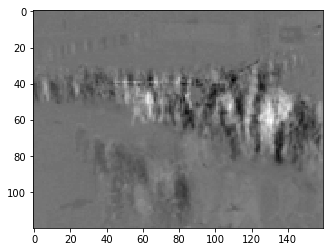

In [88]:
plt.imshow(np.reshape(Q[:,1], dims), cmap='gray');

In [89]:
smaller_matrix = Q.T @ M; smaller_matrix.shape

(10, 6000)

In [90]:
U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)

In [91]:
U = Q @ U_hat

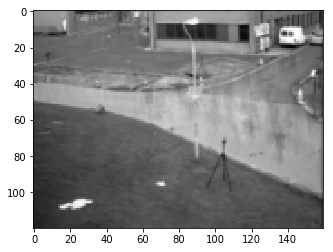

In [92]:
plt.imshow(np.reshape(U[:,0], dims), cmap='gray');

In [93]:
reconstructed_small_M = U @ np.diag(s) @ V

And the people:

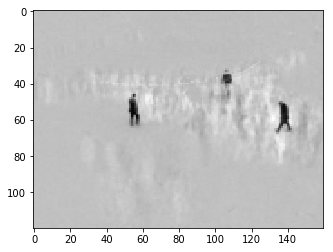

In [94]:
plt.imshow(np.reshape(M[:,0] - reconstructed_small_M[:,0], dims), cmap='gray');

### Timing Comparison

In [32]:
from sklearn import decomposition
import fbpca

Full SVD:

In [51]:
%time u, s, v = np.linalg.svd(M, full_matrices=False)

CPU times: user 5min 38s, sys: 1.53 s, total: 5min 40s
Wall time: 57.1 s


Our (overly simplified) randomized_svd from above:

In [95]:
%time u, s, v = simple_randomized_svd(M, 10)

CPU times: user 2.37 s, sys: 160 ms, total: 2.53 s
Wall time: 641 ms


Scikit learn:

In [98]:
%time u, s, v = decomposition.randomized_svd(M, 10)

CPU times: user 19.2 s, sys: 1.44 s, total: 20.7 s
Wall time: 3.67 s


Randomized SVD from Facebook's library fbpca:

In [99]:
%time u, s, v = fbpca.pca(M, 10)

CPU times: user 7.28 s, sys: 424 ms, total: 7.7 s
Wall time: 1.37 s


I would choose fbpca, since it's faster than sklearn but more robust and more accurate than our simple implementation.

Here are some results from [Facebook Research](https://research.fb.com/fast-randomized-svd/):

<img src="images/randomizedSVDbenchmarks.png" alt="" style="width: 80%"/>

#### Time and Accuracy vary with k

In [16]:
import timeit
import pandas as pd

In [29]:
U_rand, s_rand, V_rand = fbpca.pca(M, 700, raw=True)
reconstructed = U_rand @ np.diag(s_rand) @ V_rand

In [30]:
np.linalg.norm(M - reconstructed)

1.1065914828881536e-07

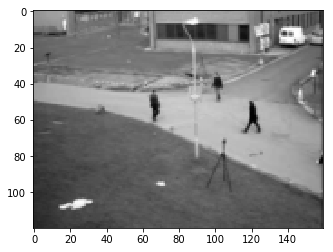

In [21]:
plt.imshow(np.reshape(reconstructed[:,140], dims), cmap='gray');

In [33]:
pd.options.display.float_format = '{:,.2f}'.format
k_values = np.arange(100,1000,100)
df_rand = pd.DataFrame(index=["time", "error"], columns=k_values)

# df_rand = pd.read_pickle("svd_df")

In [34]:
for k in k_values:
    U_rand, s_rand, V_rand = fbpca.pca(M, k, raw=True)
    reconstructed = U_rand @ np.diag(s_rand) @ V_rand
    df_rand.set_value("error", k, np.linalg.norm(M - reconstructed))
    t = timeit.timeit('fbpca.pca(M, k)', number=3, globals=globals())
    df_rand.set_value("time", k, t/3)

In [35]:
df_rand.to_pickle("df_rand")

In [117]:
df_rand

,100,200,300,400,500,600,700,800,900,1000
time,2.07,2.57,3.45,6.44,7.99,9.02,10.24,11.70,13.30,10.87
error,"58,997.27","37,539.54","26,569.89","18,769.37","12,559.34","6,936.17",0.00,0.00,0.00,0.00


In [20]:
df = pd.DataFrame(index=["error"], columns=k_values)

In [27]:
for k in k_values:
    reconstructed = U[:,:k] @ np.diag(s[:k]) @ V[:k,:]
    df.set_value("error", k, np.linalg.norm(M - reconstructed))

In [36]:
df.to_pickle("df")

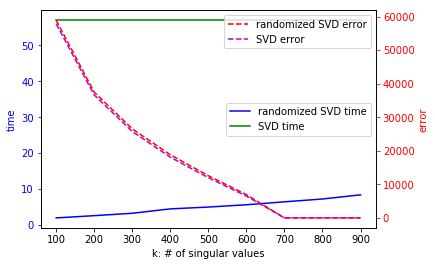

In [38]:
fig, ax1 = plt.subplots()
ax1.plot(df.columns, df_rand.loc["time"].values, 'b-', label="randomized SVD time")
ax1.plot(df.columns, np.tile([57], 9), 'g-', label="SVD time")
ax1.set_xlabel('k: # of singular values')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('time', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc = 0)

ax2 = ax1.twinx()
ax2.plot(df.columns, df_rand.loc["error"].values, 'r--', label="randomized SVD error")
ax2.plot(df.columns, df.loc["error"].values, 'm--', label="SVD error")
ax2.set_ylabel('error', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc=1)

#fig.tight_layout()
plt.show()

### Math Details

#### Process behind Randomized SVD

Here is a process to calculate a truncated SVD, described in [Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions](https://arxiv.org/pdf/0909.4061.pdf) and [summarized in this blog post](https://research.fb.com/fast-randomized-svd/):

1\. Compute an approximation to the range of $A$. That is, we want $Q$ with $r$ orthonormal columns such that $$A \approx QQ^TA$$


2\. Construct $B = Q^T A$, which is small ($r\times n$)


3\. Compute the SVD of $B$ by standard methods (fast since $B$ is smaller than $A$), $B = S\,\Sigma V^T$

4\. Since $$ A \approx Q Q^T A = Q (S\,\Sigma V^T)$$ if we set $U = QS$, then we have a low rank approximation $A \approx U \Sigma V^T$.

#### So how do we find $Q$ (in step 1)?

To estimate the range of $A$, we can just take a bunch of random vectors $w_i$, evaluate the subspace formed by $Aw_i$.  We can form a matrix $W$ with the $w_i$ as it's columns.  Now, we take the QR decomposition of $AW = QR$, then the columns of $Q$ form an orthonormal basis for $AW$, which is the range of $A$.

Since the matrix $AW$ of the product has far more rows than columns and therefore, approximately, orthonormal columns. This is simple probability - with lots of rows, and few columns, it's unlikely that the columns are linearly dependent.

#### Why M ~ Q Q.T M

We are trying to find a matrix Q such that $M \approx Q Q^T M$.  We are interested in the range of $M$, let's call this $MX$.  $Q$ has orthonormal columns so $Q^TQ = I$ (but $QQ^T$ isn't $I$, since $Q$ is rectangular)

$$ QR = MX $$
$$ QQ^TQR = QQ^TMX $$
$$ QR = QQ^TMX $$
so...
$$ MX = QQ^TMX $$

If $X$ is the identity, we'd be done (but then $X$ would be too big, and we wouldn't get the speed up we're looking for).  In our problem, $X$ is just a small random matrix.  The Johnson-Lindenstrauss Lemma provides some justification of why this works.

#### The QR Decomposition

We will be learning about the QR decomposition **in depth** later on.  For now, you just need to know that $A = QR$, where $Q$ consists of orthonormal columns, and $R$ is upper triangular.  Trefethen says that the QR decomposition is the most important idea in numerical linear algebra!  We will definitely be returning to it.

#### How should we choose $r$?

Suppose our matrix has 100 columns, and we want 5 columns in U and V. To be safe, we should project our matrix onto an orthogonal basis with a few more rows and columns than 5 (let's use 15).  At the end, we will just grab the first 5 columns of U and V

So even although our projection was only approximate, by making it a bit bigger than we need, we can make up for the loss of accuracy (since we're only taking a subset later). 

#### How this is different from random mean

In [44]:
test = M @ np.random.normal(size=(M.shape[1], 2)); test.shape

(4800, 2)

Random mean:

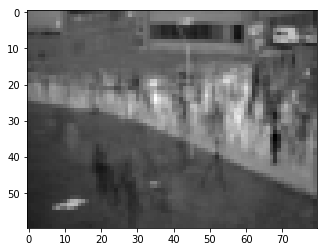

In [45]:
plt.imshow(np.reshape(test[:,0], dims), cmap='gray');

Mean image:

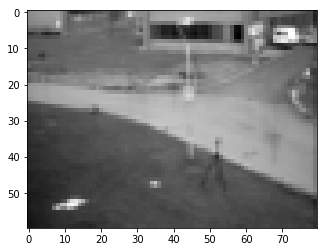

In [46]:
plt.imshow(np.reshape(M.mean(axis=1), dims), cmap='gray')

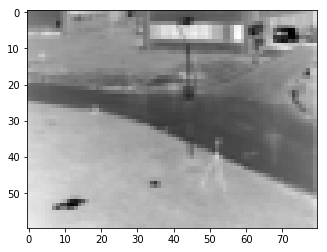

In [41]:
plt.imshow(np.reshape(test[:,1], dims), cmap='gray');

In [42]:
ut, st, vt = np.linalg.svd(test, full_matrices=False)

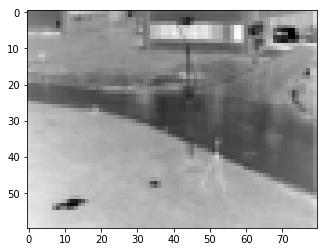

In [28]:
plt.imshow(np.reshape(smaller_matrix[0,:], dims), cmap='gray');

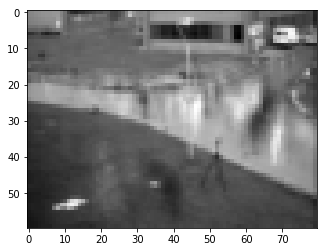

In [29]:
plt.imshow(np.reshape(smaller_matrix[1,:], dims), cmap='gray');

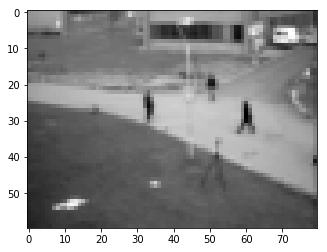

In [30]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

## Part 3: Random SVD for Topic Modeling

### Randomized SVD

Reminder: full SVD is **slow**.  This is the calculation we did above using Scipy's Linalg SVD:

In [3]:
import numpy as np

In [4]:
vectors = np.load("topics/vectors.npy")

In [5]:
vectors.shape

(2034, 26576)

In [344]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 27.2 s, sys: 812 ms, total: 28 s
Wall time: 27.9 s


In [345]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Fortunately, there is a faster way:

In [175]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

CPU times: user 144 ms, sys: 8 ms, total: 152 ms
Wall time: 154 ms


The runtime complexity for SVD is $\mathcal{O}(\text{min}(m^2 n,\; m n^2))$

**Question**: How can we speed things up?  (without new breakthroughs in SVD research)

**Idea**: Let's use a smaller matrix (with smaller $n$)!

Instead of calculating the SVD on our full matrix $A$ which is $m \times n$, let's use $B = A Q$, which is just $m \times r$ and $r << n$

We haven't found a better general SVD method, we are just using the method we have on a smaller matrix.

In [175]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

CPU times: user 144 ms, sys: 8 ms, total: 152 ms
Wall time: 154 ms


In [177]:
u.shape, s.shape, v.shape

((2034, 5), (5,), (5, 26576))

In [178]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'jpeg gif file color quality image jfif format',
 'space jesus launch god people satellite matthew atheists',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

### Randomized SVD, version 2

In [14]:
from scipy import linalg

The method `randomized_range_finder` finds an orthonormal matrix whose range approximates the range of A (step 1 in our algorithm above).  To do so, we use the LU and QR factorizations, both of which we will be covering in depth later.

I am using the [scikit-learn.extmath.randomized_svd source code](https://github.com/scikit-learn/scikit-learn/blob/14031f65d144e3966113d3daec836e443c6d7a5b/sklearn/utils/extmath.py) as a guide.

In [15]:
# computes an orthonormal matrix whose range approximates the range of A
# power_iteration_normalizer can be safe_sparse_dot (fast but unstable), LU (imbetween), or QR (slow but most accurate)
def randomized_range_finder(A, size, n_iter=5):
    Q = np.random.normal(size=(A.shape[1], size))
    
    for i in range(n_iter):
        Q, _ = linalg.lu(A @ Q, permute_l=True)
        Q, _ = linalg.lu(A.T @ Q, permute_l=True)
        
    Q, _ = linalg.qr(A @ Q, mode='economic')
    return Q

And here's our randomized SVD method:

In [33]:
def randomized_svd(M, n_components, n_oversamples=10, n_iter=4):
    
    n_random = n_components + n_oversamples
    
    Q = randomized_range_finder(M, n_random, n_iter)
    print(Q.shape)
    # project M to the (k + p) dimensional space using the basis vectors
    B = Q.T @ M
    print(B.shape)
    # compute the SVD on the thin matrix: (k + p) wide
    Uhat, s, V = linalg.svd(B, full_matrices=False)
    del B
    U = Q @ Uhat
    print(U.shape)
    
    return U[:, :n_components], s[:n_components], V[:n_components, :]

In [34]:
u, s, v = randomized_svd(vectors, 5)

(2034, 15)
(15, 26576)
(2034, 15)


#### Test

In [19]:
vectors.shape

(2034, 26576)

In [25]:
Q = np.random.normal(size=(vectors.shape[1], 10)); Q.shape

(26576, 10)

In [27]:
Q2, _ = linalg.qr(vectors @ Q, mode='economic'); Q2.shape

(2034, 10)

In [24]:
Q2.shape

(2034, 10)

#### End Test

In [238]:
%time u, s, v = randomized_svd(vectors, 5)

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 137 ms


In [18]:
u.shape, s.shape, v.shape

((2034, 5), (5,), (5, 26576))

In [247]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'image data processing analysis software available tools display']

Write a loop to calculate the error of your decomposition as you vary the # of topics.  Plot the result

#### Answer

In [248]:
#Exercise: Write a loop to calculate the error of your decomposition as you vary the # of topics


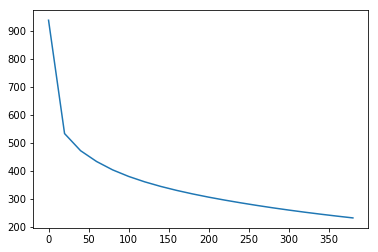

In [242]:
plt.plot(range(0,n*step,step), error)

In [175]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

CPU times: user 144 ms, sys: 8 ms, total: 152 ms
Wall time: 154 ms


In [176]:
%time u, s, v = decomposition.randomized_svd(vectors.todense(), 5)

CPU times: user 2.38 s, sys: 592 ms, total: 2.97 s
Wall time: 2.96 s


# End

**Further Resources**:
- [a whole course on randomized algorithms](http://www.cs.ubc.ca/~nickhar/W12/)